# Import modules, libraries, and packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Get the current working directory of the notebook
current_dir = os.getcwd()
# Add the parent directory of the notebook to the Python path
root_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..'))
sys.path.append(root_dir)

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import geopandas as gpd
from fiona.crs import from_epsg

# Parameters and constants

In [2]:
FILES_DIR = os.path.join(root_dir, 'gladwell/hydrology/SUMMA/summa-ml-models')

DATASET = 'CAMELS_spat_NH'

COUNTRY = 'CAN'  # 'USA' or 'CAN'

INPUT_FILES_DIR = os.path.join(FILES_DIR, DATASET)
# ATTR_FILES_DIR = os.path.join(FILES_DIR, DATASET.upper(), 'camels_attributes_v2.0')
BASIN_SET_FILES_DIR = os.path.join(INPUT_FILES_DIR, 'merged_lumped_shapes')

# FORCINGS = ['daymet', 'nldas', 'maurer']
# FORCINGS_dict = {
#     'daymet': 'cida',
#     'nldas': 'nldas',
#     'maurer': 'maurer',
# }

# HRU_IDS = [
#     'CAN_01AD002',
#     'CAN_01AL003',
#     'CAN_01AF007',
#     'CAN_01AJ003',
#     'CAN_01AJ004',
#     'CAN_01AJ010',
#     'CAN_01AK001',
#     'CAN_01AK006',
#     'CAN_01AK007',
#     'CAN_01AL002'
# ]

## Loading basin IDs

In [3]:
##Read the basin shapefile
gdf_basins = gpd.read_file(os.path.join(BASIN_SET_FILES_DIR, 'merged_lumped_outlines.shp'))
# # merged_lumped_outlines
# camels_new_delineation = gpd.read_file(os.path.join(BASIN_SET_FILES_DIR, 'camels_new_delineation.shp'))

gdf_borders = gpd.read_file(os.path.join(INPUT_FILES_DIR, 'NA_PoliticalDivision/boundaries_p_2021_v3.shp'))
states = gpd.read_file(os.path.join(BASIN_SET_FILES_DIR, 'USA_Canada_ShapefileMerge.shp'))

In [4]:
# Set the CRS for gdf_basins
gdf_basins.crs = from_epsg(4326)

# Set a common CRS for both GeoDataFrames
common_crs = 'ESRI:102008'
gdf_basins = gdf_basins.to_crs(common_crs)

gdf_borders = gdf_borders.to_crs(common_crs)
gdf_borders = gdf_borders.set_crs(common_crs, allow_override=True)

In [13]:
gdf_borders = gdf_borders.to_crs(common_crs)
gdf_borders = gdf_borders.set_crs(common_crs, allow_override=True)

# Catchments plots

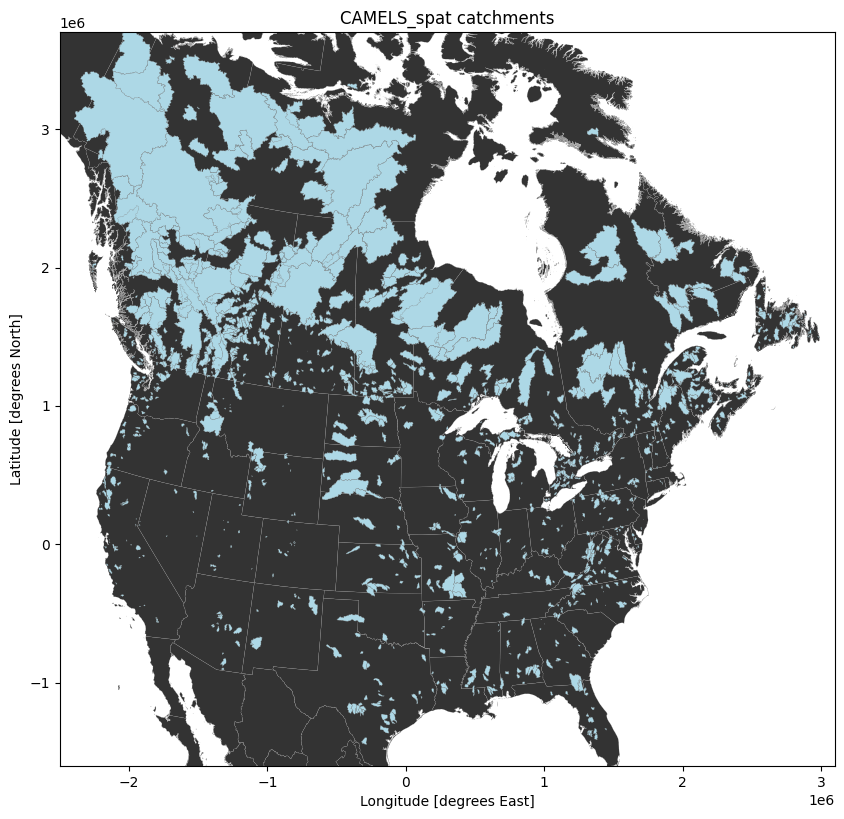

In [15]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the reprojected gdf_borders
# gdf_borders.boundary.plot(ax=ax, color=None, edgecolor='k', linewidth=0.1)
gdf_borders.plot(ax=ax, facecolor='0.2',edgecolor='0.7', linewidth=0.1)

# Plot the merged_lumped_outlines
gdf_basins.plot(ax=ax, color='lightblue', edgecolor='gray', linewidth=0.1)

# Chart junk
ax.set_xlim([-2.5*1e6, 3.1*1e6])
ax.set_ylim([-1.6*1e6, 3.7*1e6])

ax.set_title("CAMELS_spat catchments")
ax.set_xlabel('Longitude [degrees East]')
ax.set_ylabel('Latitude [degrees North]')

# Show the plot
plt.show()